## Assignment #2

* Release date: 2020/05/04
* Due date: **2020/05/13 23:59** (will not accept late submission)
* Submittion format: notebook file which can be executed in Colab environment
* Weighting: 5% (total 50 pts)
* You will build a multi-class classification model using Reuters dataset.

> ### Loading and preprocessing data

In [ ]:
from tensorflow.keras.datasets import reuters
import tensorflow as tf

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step


* (10pts) Write the codes for preprocessing data
  * For inputs, the data we have should be converted to binary vectors.
  * For labels, determine an appropriate format by referring to the arguments of model.compile function below.

In [ ]:
# write preprocessing codes

In [ ]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = train_labels.astype('float32')
y_test = test_labels.astype('float32')

> ### Building the network

In [ ]:
# Do not modify this block
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [ ]:
# Do not modify this block
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


> ### Validation

* We employ *k-fold cross validation* as validation method of our model.
* **(15pts)** Write a code in the below to perform *10-fold cross validation*.
* **For each fold, save a model at every epoch in your Google Drive.**

In [ ]:
import numpy as np
import os

# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# callback for saving model
from tensorflow.keras.callbacks import ModelCheckpoint

k = 10 # 10-fold cross validation
num_val_samples = len(x_train) // k
num_epochs = 20
all_acc_histories = []

model.save_weights('/content/gdrive/My Drive/exp/hw2/weights_reset.hdf5')

for i in range(k):
  model.load_weights('/content/gdrive/My Drive/exp/hw2/weights_reset.hdf5')

  print('processing fold #', i)
  
  root_fold = '/content/gdrive/My Drive/exp/hw2/fold{:02d}'.format(i+1)
  
  # check the directory for saving the models
  if not os.path.exists(root_fold):
    os.makedirs(root_fold)
  
  filepath = os.path.join(root_fold,'model.{epoch:02d}.hdf5')
  modelckpt = ModelCheckpoint(filepath=filepath)
  
  val_data = x_train[i*num_val_samples: (i+1)*num_val_samples]
  val_targets = y_train[i*num_val_samples: (i+1)*num_val_samples]
  
  partial_train_data = np.concatenate([x_train[:i*num_val_samples],
                                       x_train[(i+1)*num_val_samples:]],
                                      axis=0)
  partial_train_targets = np.concatenate([y_train[:i*num_val_samples],
                                          y_train[(i+1)*num_val_samples:]],
                                         axis=0)
  
  history = model.fit(partial_train_data, 
                      partial_train_targets,
                      validation_data=(val_data, val_targets),
                      epochs=num_epochs,
                      batch_size=512, 
                      callbacks=[modelckpt], 
                      verbose=1)
  acc_history = history.history['val_accuracy']
  all_acc_histories.append(acc_history)
  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
processing fold # 0
Epoch 1/20
16/16 [==============================] - 3s 211ms/step - loss: 2.5248 - accuracy: 0.5361 - val_loss: 1.6758 - val_accuracy: 0.6481
Epoch 2/20
16/16 [==============================] - 7s 453ms/step - loss: 1.3497 - accuracy: 0.7171 - val_loss: 1.2915 - val_accuracy: 0.7127
Epoch 3/20
16/16 [==============================] - 2s 122ms/step - loss: 1.0016 - accuracy: 0.7871 - val_loss: 1.1319 - val_accuracy: 0.7550
Epoch 4/20
16/16 

* **(10pts)** Plotting the training and validation accuracy
  * To obtain the validation accuracy at the end of every epoch, just average the performances of all folds.

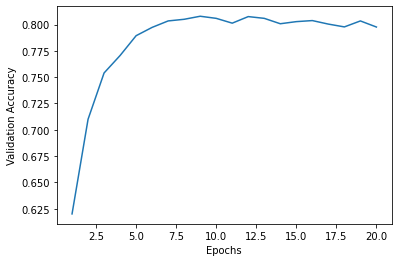

In [ ]:
import matplotlib.pyplot as plt

average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_acc_history)+1), average_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

In [ ]:
# best epoch
epochs = np.argmax(np.array(average_acc_history))
epochs

8

> ### (15pts) Inference

* Find the best performance model by seeing the performance plot.
* Calculate the accuracy on test set using the best performance model.
  * Here, you should use a majority voting method to get the prediction for a test data point.
  * Specifically, given a test data point, get the predicted class from the trained model on each fold, and then decide the final predicted class by a majority voting.
* **Do not retrain the model.**

In [ ]:
predicted_classes = []
for i in range(10):
  best_model_path = '/content/gdrive/My Drive/exp/hw2/fold{0:02d}/model.{1:02d}.hdf5'.format(i+1, epochs+1)
  best_model = models.load_model(filepath=best_model_path)

  predictions = best_model.predict(x_test)
  predicted_class = np.argmax(predictions, axis=1)
  
  predicted_classes.append(predicted_class)

# do majority voting


In [ ]:
[i[1] for i in predicted_classes]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

In [ ]:
# do majority voting
predicted_classes_arr = np.array(predicted_classes).transpose()

from scipy.stats import mode
voted = mode(predicted_classes_arr, axis=1)[0].flatten()

# compute accuracy
sum(test_labels == voted) / len(test_labels)


0.8018699910952805

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Asparagus_001.jpg to Asparagus_001.jpg


In [ ]:
uploaded.resize((150, 150))

In [ ]:
from PIL import Image
import os
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
image_path = '/content/gdrive/My Drive/ab.jpg'

In [ ]:
image = Image.open(image_path)

In [ ]:
image

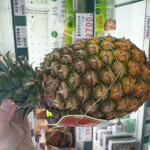

In [ ]:
image.resize((150, 150))